Importação das bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



In [ ]:
# Carregue o dataset
data = pd.read_csv('/content/drive/MyDrive/Case_VendasProdutos/Sample_Superstore.csv')  # Substitua 'seuarquivo.csv' pelo caminho do seu arquivo

In [ ]:
# Substitua as vírgulas por pontos na coluna 'Sales'
data['Sales'] = data['Sales'].str.replace(',', '.', regex=True)

In [ ]:
# Converta 'Order Date' para formato de data
data['Order Date'] = pd.to_datetime(data['Order Date'])


In [ ]:
# Selecione as colunas relevantes (por exemplo, 'Order Date' e 'Sales')
df = data[['Order Date', 'Sales']]

In [ ]:
# Converta a coluna 'Sales' para o tipo numérico
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')



<ipython-input-6-dd7ad01e782d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')


In [ ]:
# Defina 'Order Date' como índice
df = df.set_index('Order Date')



In [ ]:
# Agrupe as vendas por mês e some os valores
df_monthly = df.resample('M').sum()



In [ ]:
# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
sales_normalized = scaler.fit_transform(np.array(df_monthly['Sales']).reshape(-1, 1))

# Função para criar sequências temporais
def create_sequences(data, seq_length):
    sequences = []
    target = []
    for i in range(len(data)-seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        target.append(label)
    return np.array(sequences), np.array(target)



In [ ]:
# Escolha do comprimento da sequência temporal
sequence_length = 12  # Pode ajustar conforme necessário



In [ ]:
# Criação de sequências temporais
X, y = create_sequences(sales_normalized, sequence_length)



In [ ]:
# Divisão dos dados em treinamento e teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]



In [ ]:
# Reshape dos dados para o formato aceito pela LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))



In [ ]:
# Criação do modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [ ]:
# Treinamento do modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
1/1 - 5s - loss: 0.1462 - val_loss: 0.3352 - 5s/epoch - 5s/step
Epoch 2/50
1/1 - 0s - loss: 0.1301 - val_loss: 0.3047 - 161ms/epoch - 161ms/step
Epoch 3/50
1/1 - 0s - loss: 0.1155 - val_loss: 0.2761 - 192ms/epoch - 192ms/step
Epoch 4/50
1/1 - 0s - loss: 0.1022 - val_loss: 0.2492 - 230ms/epoch - 230ms/step
Epoch 5/50
1/1 - 0s - loss: 0.0902 - val_loss: 0.2239 - 162ms/epoch - 162ms/step
Epoch 6/50
1/1 - 0s - loss: 0.0794 - val_loss: 0.2001 - 217ms/epoch - 217ms/step
Epoch 7/50
1/1 - 0s - loss: 0.0697 - val_loss: 0.1778 - 246ms/epoch - 246ms/step
Epoch 8/50
1/1 - 0s - loss: 0.0612 - val_loss: 0.1569 - 255ms/epoch - 255ms/step
Epoch 9/50
1/1 - 0s - loss: 0.0539 - val_loss: 0.1374 - 131ms/epoch - 131ms/step
Epoch 10/50
1/1 - 0s - loss: 0.0477 - val_loss: 0.1195 - 59ms/epoch - 59ms/step
Epoch 11/50
1/1 - 0s - loss: 0.0428 - val_loss: 0.1032 - 50ms/epoch - 50ms/step
Epoch 12/50
1/1 - 0s - loss: 0.0392 - val_loss: 0.0887 - 51ms/epoch - 51ms/step
Epoch 13/50
1/1 - 0s - loss: 0.0370 -

In [ ]:
# Avaliação do modelo nos dados de teste
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))



1/1 [==============================] - 0s 424ms/step


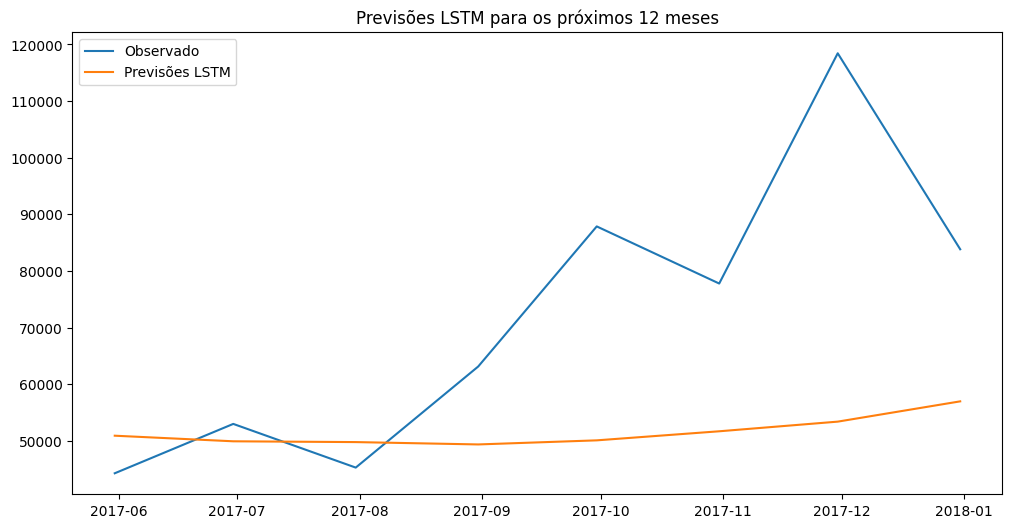

In [ ]:
# Exibição dos resultados
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index[train_size+sequence_length:], y_test, label='Observado')
plt.plot(df_monthly.index[train_size+sequence_length:], test_predictions, label='Previsões LSTM')
plt.title('Previsões LSTM para os próximos 12 meses')
plt.legend()
plt.show()


In [ ]:
# Criação do DataFrame para visualização com Plotly
df_plot = pd.DataFrame({'Date': df_monthly.index[train_size+sequence_length:], 'Observado': y_test.flatten(), 'Previsões LSTM': test_predictions.flatten()})

# Criação do gráfico interativo com Plotly
fig = px.line(df_plot, x='Date', y=['Observado', 'Previsões LSTM'], title='Previsões LSTM para os próximos 12 meses',
              labels={'value': 'Vendas', 'Date': 'Data'}, line_shape='linear', template='plotly_dark')

# Adiciona legenda
fig.update_layout(legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1))

# Exibição do gráfico interativo
fig.show()


In [ ]:
# Criação do DataFrame para visualização com Plotly
df_plot = pd.DataFrame({'Date': df_monthly.index, 'Observado': df_monthly['Sales'], 'Previsões LSTM': np.nan})
df_plot.loc[df_monthly.index[train_size+sequence_length:], 'Previsões LSTM'] = test_predictions.flatten()

# Criação do gráfico interativo com Plotly
fig = go.Figure()

# Adiciona a série temporal observada
fig.add_trace(go.Scatter(x=df_plot['Date'], y=df_plot['Observado'], mode='lines', name='Observado'))

# Adiciona as previsões da LSTM
fig.add_trace(go.Scatter(x=df_plot['Date'], y=df_plot['Previsões LSTM'], mode='lines', name='Previsões LSTM'))

# Atualiza o layout do gráfico
fig.update_layout(title='Série Temporal e Previsões LSTM',
                  xaxis_title='Data',
                  yaxis_title='Vendas',
                  template='plotly_dark')

# Exibição do gráfico interativo
fig.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Inverter a normalização para obter valores reais
y_test_desnormalizado = scaler.inverse_transform(y_test)

# Calcular as previsões desnormalizadas
test_predictions_desnormalizado = scaler.inverse_transform(test_predictions)

# Calcular métricas
mae = mean_absolute_error(y_test_desnormalizado, test_predictions_desnormalizado)
mse = mean_squared_error(y_test_desnormalizado, test_predictions_desnormalizado)
rmse = np.sqrt(mse)

# Imprimir as métricas
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


MAE: 2617449194.393371
MSE: 1.1888630713390217e+19
RMSE: 3447989372.575011


In [ ]:
# Criar um DataFrame com datas e valores previstos
df_predicoes = pd.DataFrame({'Date': df_monthly.index[train_size+sequence_length:],
                             'Previsões LSTM': test_predictions.flatten()})

# Inverter a normalização para obter valores reais
df_predicoes['Previsões LSTM'] = scaler.inverse_transform(df_predicoes['Previsões LSTM'].values.reshape(-1, 1))

# Exibir o DataFrame de previsões
print(df_predicoes)


        Date  Previsões LSTM
0 2017-05-31    5.798747e+09
1 2017-06-30    5.686160e+09
2 2017-07-31    5.670188e+09
3 2017-08-31    5.622916e+09
4 2017-09-30    5.705178e+09
5 2017-10-31    5.887665e+09
6 2017-11-30    6.081772e+09
7 2017-12-31    6.489989e+09


In [ ]:
import plotly.graph_objects as go

# Criar DataFrame para visualização com Plotly
df_visualizacao = pd.DataFrame({'Date': df_monthly.index, 'Observado': df_monthly['Sales'], 'Previsões LSTM': np.nan})
df_visualizacao.loc[df_monthly.index[train_size+sequence_length:], 'Previsões LSTM'] = test_predictions.flatten()

# Inverter a normalização para obter valores reais
df_visualizacao['Previsões LSTM'] = scaler.inverse_transform(df_visualizacao['Previsões LSTM'].values.reshape(-1, 1))

# Criar gráfico interativo com Plotly
fig = go.Figure()

# Adicionar a série temporal observada
fig.add_trace(go.Scatter(x=df_visualizacao['Date'], y=df_visualizacao['Observado'], mode='lines', name='Observado'))

# Adicionar as previsões da LSTM
fig.add_trace(go.Scatter(x=df_visualizacao['Date'], y=df_visualizacao['Previsões LSTM'], mode='lines', name='Previsões LSTM'))

# Atualizar o layout do gráfico
fig.update_layout(title='Série Temporal e Previsões LSTM - Treino e Teste',
                  xaxis_title='Data',
                  yaxis_title='Vendas',
                  template='plotly_dark')

# Exibir o gráfico interativo
fig.show()


In [ ]:
import plotly.graph_objects as go

# Criar DataFrame para visualização com Plotly
df_visualizacao = pd.DataFrame({'Date': df_monthly.index, 'Observado': df_monthly['Sales'], 'Previsões LSTM': np.nan})
df_visualizacao.loc[df_monthly.index[train_size+sequence_length:], 'Previsões LSTM'] = test_predictions.flatten()

# Inverter a normalização para obter valores reais
df_visualizacao['Observado'] = scaler.inverse_transform(df_visualizacao['Observado'].values.reshape(-1, 1))
df_visualizacao['Previsões LSTM'] = scaler.inverse_transform(df_visualizacao['Previsões LSTM'].values.reshape(-1, 1))

# Criar gráfico interativo com Plotly
fig = go.Figure()

# Adicionar a série temporal observada
fig.add_trace(go.Scatter(x=df_visualizacao['Date'], y=df_visualizacao['Observado'], mode='lines', name='Observado'))

# Adicionar as previsões da LSTM
fig.add_trace(go.Scatter(x=df_visualizacao['Date'], y=df_visualizacao['Previsões LSTM'], mode='lines', name='Previsões LSTM'))

# Atualizar o layout do gráfico
fig.update_layout(title='Série Temporal e Previsões LSTM - Treino e Teste',
                  xaxis_title='Data',
                  yaxis_title='Vendas',
                  template='plotly_dark')

# Exibir o gráfico interativo
fig.show()


In [ ]:
# Calcular as diferenças percentuais
df_visualizacao['Diferença Percentual'] = ((df_visualizacao['Previsões LSTM'] - df_visualizacao['Observado']) / df_visualizacao['Observado']) * 100

# Exibir o DataFrame com as diferenças percentuais
print(df_visualizacao[['Date', 'Diferença Percentual']])


                 Date  Diferença Percentual
Order Date                                 
2014-01-31 2014-01-31                   NaN
2014-02-28 2014-02-28                   NaN
2014-03-31 2014-03-31                   NaN
2014-04-30 2014-04-30                   NaN
2014-05-31 2014-05-31                   NaN
2014-06-30 2014-06-30                   NaN
2014-07-31 2014-07-31                   NaN
2014-08-31 2014-08-31                   NaN
2014-09-30 2014-09-30                   NaN
2014-10-31 2014-10-31                   NaN
2014-11-30 2014-11-30                   NaN
2014-12-31 2014-12-31                   NaN
2015-01-31 2015-01-31                   NaN
2015-02-28 2015-02-28                   NaN
2015-03-31 2015-03-31                   NaN
2015-04-30 2015-04-30                   NaN
2015-05-31 2015-05-31                   NaN
2015-06-30 2015-06-30                   NaN
2015-07-31 2015-07-31                   NaN
2015-08-31 2015-08-31                   NaN
2015-09-30 2015-09-30           

In [ ]:
pip install neuralprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.2/378.2 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 84.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.2/185.2 kB 22

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning:

Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [97.917]% of the data.
INFO:NP.df_utils:Major frequency M corresponds to [97.917]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as M
INFO:NP.df_utils:Dataframe freq automatically defined as M
INFO - (NP.config.init_data_params) - Setting normalization to glob

Finding best initial lr:   0%|          | 0/204 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [97.917]% of the data.
INFO:NP.df_utils:Major frequency M corresponds to [97.917]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO:NP.df_utils:Defined frequency is equal to major frequency - M
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [91.667]% of the data.
INFO:NP.df_utils:Major frequency M corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO:NP.df_utils:Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [91.667]% of the data.
INFO:NP.df_utils:Major frequency M corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined 

Predicting: 3it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


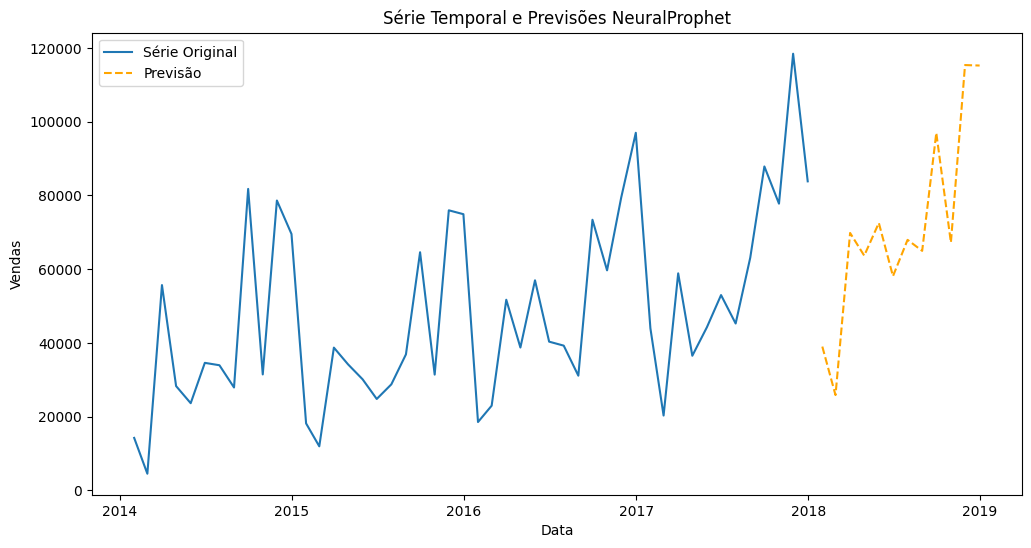

Métricas de Avaliação:
MAE (Erro Médio Absoluto): 13392.87
MSE (Erro Quadrático Médio): 287335887.94
RMSE (Raiz do Erro Quadrático Médio): 16950.98


In [ ]:
from neuralprophet import NeuralProphet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Criar um DataFrame com as colunas 'ds' (data) e 'y' (vendas)
df_prophet = pd.DataFrame({'ds': df_monthly.index, 'y': df_monthly['Sales']})

# Criar e treinar o modelo Neural Prophet
model = NeuralProphet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(df_prophet)

# Criar um DataFrame com datas futuras para fazer previsões
future = model.make_future_dataframe(df_prophet, periods=12)

# Fazer previsões para os próximos 12 meses
forecast = model.predict(future)

# Visualizar os resultados
fig, ax = plt.subplots(figsize=(12, 6))

# Plotar a série original
ax.plot(df_prophet['ds'], df_prophet['y'], label='Série Original')

# Plotar a previsão
ax.plot(forecast['ds'], forecast['yhat1'], label='Previsão', linestyle='--', color='orange')

# Adicionar rótulos e legenda
ax.set_title('Série Temporal e Previsões NeuralProphet')
ax.set_xlabel('Data')
ax.set_ylabel('Vendas')
ax.legend()

# Exibir o gráfico
plt.show()

# Calcular métricas
y_true = df_prophet['y'][-12:]
y_pred = forecast['yhat1'][-12:]

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

common_dates = y_true.index.intersection(y_pred.index)
y_true = y_true[common_dates]
y_pred = y_pred[common_dates]

# Calcular diferença percentual
percent_diff = ((y_true - y_pred) / y_true) * 100

# Apresentar métricas
print(f'Métricas de Avaliação:')
print(f'MAE (Erro Médio Absoluto): {mae:.2f}')
print(f'MSE (Erro Quadrático Médio): {mse:.2f}')
print(f'RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f}')
